# Taller Práctico: Regresión Logística (Versión Completa y Corregida)

**Curso:** Maestría en Machine Learning

**Nota:** Esta versión incorpora las correcciones de preprocesamiento discutidas: la correcta creación de variables dummy (0/1) y la estandarización de features numéricos, presentando el flujo de trabajo metodológicamente correcto y completo.

## 1. Importación de Librerías

In [ ]:
!pip install ISLP

In [2]:
# Librerías para manipulación de datos
import pandas as pd
import numpy as np

# Librerías para visualización
import plotly.express as px
import plotly.graph_objects as go
from matplotlib import pyplot as plt

# Librerías de Machine Learning (scikit-learn)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report,
    roc_curve,
    roc_auc_score
)

# Librería para cargar el dataset
from ISLP import load_data

## 2. Carga y Preprocesamiento de Datos

In [3]:
# Carga de datos
default_df = load_data('Default')

# Conversión de categóricas a numéricas
df_processed = pd.get_dummies(default_df, columns=['student'], drop_first=True, dtype=int)
df_processed['default'] = df_processed['default'].apply(lambda x: 1 if x == 'Yes' else 0)

# Definición de features y target
X = df_processed[['balance', 'income', 'student_Yes']]
y = df_processed['default']

print("Primeras filas de los datos preprocesados:")
display(X.head())

Primeras filas de los datos preprocesados:


,balance,income,student_Yes
0,729.526495,44361.625074,0
1,817.180407,12106.134700,1
2,1073.549164,31767.138947,0
3,529.250605,35704.493935,0
4,785.655883,38463.495879,0


### División en Conjuntos de Entrenamiento y Prueba

Dividimos los datos ANTES de cualquier preprocesamiento que "aprenda" de los datos, como la estandarización, para evitar fuga de información.

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print(f"Forma de X_train: {X_train.shape}")
print(f"Forma de X_test: {X_test.shape}")

Forma de X_train: (8000, 3)
Forma de X_test: (2000, 3)


### Estandarización de Features Numéricos

**Este es un paso crucial.** Estandarizamos las variables `balance` e `income` para que tengan media 0 y desviación estándar 1. Esto asegura que la regularización del modelo se aplique de manera justa.

**Importante:** Ajustamos el `StandardScaler` **únicamente** con los datos de entrenamiento (`X_train`) y luego lo usamos para transformar tanto el conjunto de entrenamiento como el de prueba.

In [5]:
# Instanciamos el escalador
scaler = StandardScaler()

# Columnas a escalar
cols_to_scale = ['balance', 'income']

# Creamos copias para no modificar los dataframes originales
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

# Ajustamos y transformamos los datos de entrenamiento
X_train_scaled[cols_to_scale] = scaler.fit_transform(X_train[cols_to_scale])

# Transformamos los datos de prueba con el escalador ya ajustado
X_test_scaled[cols_to_scale] = scaler.transform(X_test[cols_to_scale])

print("Primeras filas de los datos de entrenamiento escalados:")
display(X_train_scaled.head())

Primeras filas de los datos de entrenamiento escalados:


,balance,income,student_Yes
2720,-0.018061,-0.331140,1
6168,-1.687480,2.194023,0
7723,-0.123917,-0.288274,0
8128,0.155670,0.992420,0
3565,0.449485,-1.673192,1


## 3. Entrenamiento del Modelo de Regresión Logística

Ahora entrenaremos el modelo usando los datos estandarizados.

In [6]:
# Instanciamos y entrenamos el modelo con los datos escalados
log_reg = LogisticRegression(random_state=42)#, solver='liblinear')
log_reg.fit(X_train_scaled, y_train)

print("¡Modelo entrenado exitosamente con datos escalados!")

¡Modelo entrenado exitosamente con datos escalados!


## 4. Evaluación del Modelo

Procedemos a la evaluación completa del modelo sobre el conjunto de prueba escalado.

### 4.1. Matriz de Confusión y Métricas Clave

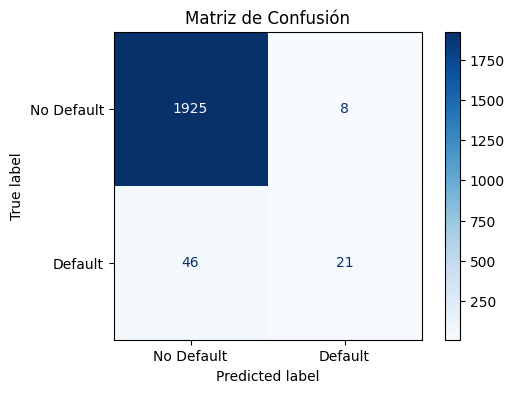


Reporte de Clasificación:
              precision    recall  f1-score   support

  No Default       0.98      1.00      0.99      1933
     Default       0.72      0.31      0.44        67

    accuracy                           0.97      2000
   macro avg       0.85      0.65      0.71      2000
weighted avg       0.97      0.97      0.97      2000



In [7]:
# Realizamos predicciones sobre el conjunto de prueba escalado
y_pred = log_reg.predict(X_test_scaled)

# Calculamos y visualizamos la matriz de confusión
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Default', 'Default'])
fig, ax = plt.subplots(figsize=(6, 4))
disp.plot(cmap='Blues', ax=ax)
ax.set_title('Matriz de Confusión')
plt.show()

# Imprimimos el reporte de clasificación completo
print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred, target_names=['No Default', 'Default']))

### 4.2. El Impacto del Umbral de Decisión

Reporte de Clasificación con Umbral = 0.2:
              precision    recall  f1-score   support

  No Default       0.99      0.97      0.98      1933
     Default       0.39      0.63      0.48        67

    accuracy                           0.95      2000
   macro avg       0.69      0.80      0.73      2000
weighted avg       0.97      0.95      0.96      2000



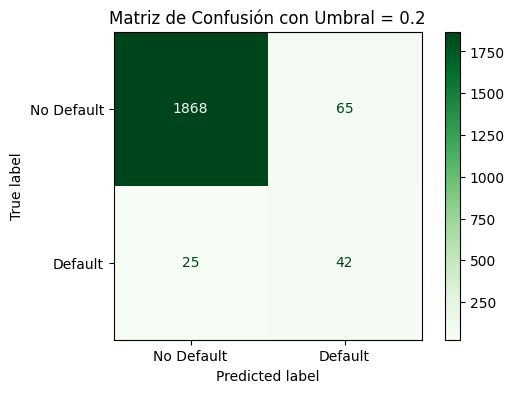

In [8]:
# Obtenemos las probabilidades de predicción para la clase positiva (Default)
y_pred_proba = log_reg.predict_proba(X_test_scaled)[:, 1]

# Aplicamos un nuevo umbral de 0.2 para aumentar el Recall
umbral = 0.2
y_pred_nuevo_umbral = (y_pred_proba >= umbral).astype(int)

print(f"Reporte de Clasificación con Umbral = {umbral}:")
print(classification_report(y_test, y_pred_nuevo_umbral, target_names=['No Default', 'Default']))

# Visualizamos la nueva matriz de confusión
cm_nuevo = confusion_matrix(y_test, y_pred_nuevo_umbral)
disp_nuevo = ConfusionMatrixDisplay(confusion_matrix=cm_nuevo, display_labels=['No Default', 'Default'])
fig, ax = plt.subplots(figsize=(6, 4))
disp_nuevo.plot(cmap='Greens', ax=ax)
ax.set_title(f'Matriz de Confusión con Umbral = {umbral}')
plt.show()

### 4.3. Curva ROC y AUC

In [9]:
# Calculamos la tasa de verdaderos positivos (tpr) y la tasa de falsos positivos (fpr)
fpr, tpr, umbrales = roc_curve(y_test, y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)

# Creamos el gráfico con Plotly
fig = go.Figure()
fig.add_trace(go.Scatter(x=fpr, y=tpr, mode='lines', name=f'Curva ROC (AUC = {auc:.4f})'))
fig.add_trace(go.Scatter(x=[0, 1], y=[0, 1], mode='lines', name='Clasificador Aleatorio', line=dict(dash='dash')))
fig.update_layout(
    title='Curva ROC para el Modelo de Regresión Logística',
    xaxis_title='Tasa de Falsos Positivos (FPR)',
    yaxis_title='Tasa de Verdaderos Positivos (TPR)',
    template='plotly_white'
)
fig.show()

In [10]:
pd.DataFrame({
    'Umbral': umbrales,
    'FPR': fpr,
    'TPR': tpr
})  # Mostramos las primeras filas de los umbrales y sus correspondientes FPR y TPR

,Umbral,FPR,TPR
0,inf,0.000000,0.000000
1,0.904982,0.000000,0.014925
2,0.876104,0.000000,0.029851
3,0.861995,0.000517,0.029851
4,0.723316,0.000517,0.179104
...,...,...,...
87,0.007660,0.320228,0.970149
88,0.007620,0.320228,0.985075
89,0.007012,0.332644,0.985075
90,0.007008,0.332644,1.000000


## 5. Regularización

El hiperparámetro `C` en `scikit-learn` es el inverso de la fuerza de regularización $\lambda$. Un valor de `C` pequeño implica una regularización más fuerte. Ahora que los datos están escalados, la comparación de coeficientes es mucho más justa.

In [11]:
# Modelo con regularización L2 (Ridge) - C=1.0 (default)
log_reg_l2 = LogisticRegression(penalty='l2', C=1.0, solver='liblinear', random_state=42).fit(X_train_scaled, y_train)

# Modelo con regularización L1 (Lasso) - C=1.0 (default)
log_reg_l1 = LogisticRegression(penalty='l1', C=1.0, solver='liblinear', random_state=42).fit(X_train_scaled, y_train)

# Ahora con regularización más fuerte (C=0.1)
log_reg_l2_strong = LogisticRegression(penalty='l2', C=0.1, solver='liblinear', random_state=42).fit(X_train_scaled, y_train)
log_reg_l1_strong = LogisticRegression(penalty='l1', C=0.1, solver='liblinear', random_state=42).fit(X_train_scaled, y_train)

# Creamos un DataFrame para comparar los coeficientes
coef_df = pd.DataFrame({
    'Predictor': X.columns,
    'Coef_L2 (C=1.0)': log_reg_l2.coef_[0],
    'Coef_L1 (C=1.0)': log_reg_l1.coef_[0],
    'Coef_L2_fuerte (C=0.1)': log_reg_l2_strong.coef_[0],
    'Coef_L1_fuerte (C=0.1)': log_reg_l1_strong.coef_[0]
})

print("Comparación de Coeficientes con Regularización (Datos Escalados):")
display(coef_df)

Comparación de Coeficientes con Regularización (Datos Escalados):


,Predictor,Coef_L2 (C=1.0),Coef_L1 (C=1.0),Coef_L2_fuerte (C=0.1),Coef_L1_fuerte (C=0.1)
0,balance,2.594626,2.709366,1.921343,2.389894
1,income,-0.054058,-0.004069,-0.106268,0.002709
2,student_Yes,-0.658059,-0.561404,-0.670900,-0.323989


**Análisis:**
- Ahora los coeficientes son directamente comparables en magnitud.
- Se puede observar claramente cómo al aumentar la fuerza de la regularización (disminuir `C`), los coeficientes se "encogen" hacia cero.
- La regularización L1 es más agresiva y puede llevar coeficientes a cero, realizando una selección de variables.

## 6. Preguntas y Desafíos para Experimentar

Ahora te toca a ti. Intenta responder a las siguientes preguntas modificando el código anterior para solidificar tu aprendizaje:

1.  **Fuerza de Regularización vs. Rendimiento:** Crea un gráfico que muestre cómo cambia el AUC del modelo a medida que varías el hiperparámetro `C` (p. ej. `[0.001, 0.01, 0.1, 1, 10, 100]`). ¿Encuentras un valor óptimo para `C`?
2.  **Otros Escaladores:** En lugar de `StandardScaler`, prueba con `MinMaxScaler` de `sklearn.preprocessing`. ¿Cambian los resultados de rendimiento? ¿Y los coeficientes del modelo?
3.  **Selección de Predictores:** Entrena el modelo usando solo `balance` y `student_Yes` (ambos escalados). ¿Cuánto cae el rendimiento (AUC) al quitar la variable `income`? ¿Confirma esto que `income` es el predictor menos importante?

## 7. Ejercicios Propuestos

1.  Explica con tus propias palabras por qué el accuracy no es una buena métrica para evaluar un modelo en un dataset desbalanceado como `Default`.
2.  Si un banco te pide un modelo que minimice la cantidad de clientes en default que no son detectados, ¿en qué métrica te enfocarías (Precisión o Recall)? ¿Y cómo ajustarías el umbral de decisión?
3.  Carga un nuevo dataset de clasificación de `scikit-learn` (por ejemplo, `load_breast_cancer`) y realiza un análisis completo: estandarización, entrenamiento, evaluación con matriz de confusión y reporte de clasificación.
4.  ¿Qué representa un punto en la esquina superior izquierda de la curva ROC? ¿Y un punto en la línea diagonal?
5.  ¿Por qué es fundamental ajustar (`fit`) el `StandardScaler` únicamente con los datos de entrenamiento y no con todo el dataset?
6.  Crea un bucle `for` que itere sobre una lista de umbrales (ej. `[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]`). Para cada umbral, calcula y guarda la Precisión y el Recall para la clase 'Default'. Luego, grafica cómo cambian estas dos métricas a medida que varía el umbral (Precision-Recall Curve).
7.  Usando los coeficientes del modelo `log_reg` (entrenado con datos escalados), interpreta el coeficiente de la variable `balance`. ¿Qué significa un aumento de una desviación estándar en el `balance` en términos del odds ratio de default?
8.  Explica la diferencia fundamental entre la regularización L1 y L2 en términos de su efecto sobre los coeficientes del modelo.
9.  Si tuvieras dos modelos, uno con AUC de 0.85 y otro con AUC de 0.75, ¿cuál elegirías y por qué? ¿Bajo qué circunstancias podrías preferir el de 0.75?
10. Investiga el parámetro `class_weight` de `LogisticRegression` en `scikit-learn`. ¿Cómo podrías usarlo para manejar el desbalanceo de clases en el dataset `Default`? Pruébalo (con los datos escalados) y compara los resultados (recall, precisión) con la técnica de ajustar el umbral.

In [ ]:
# Ejercicios 1
# El dataset desbalanceado, no sirve a la hora de predecir; ya que suponiendo que tenemos un set